# simulating data to test model recovery

# PTN

The PT+N theory says that a set of samples are drawn and then read with noise. The samples are drawn from a mental model with a true rate $\rho$.

$$S \sim Binomial(N, \rho)$$

Then they are read with noise, where $d$ represents the probability a sample is misread. This can be folded into the Binomial distribution, as:

$$ S_{read} \sim Binomial(N, (1-2d)\rho  + d)$$

And

$$ P(x) = \frac{S_{read}(x)}{N}$$

# Bayesian sampler

The Bayesian Sampler model is a bit different. In this model, samples are combined with a prior to perform a bayesian inference about the true probability. The model assumes that the response given is the posterior expectation.

Like ith PT+N, the samples are 

$$S \sim^{iid} Binomial(N, \rho)$$

But the estimate is instead

$$P(x) =  \frac{S(x) + \beta}{N + 2 \beta}$$

The _autocorrelated bayesian sampler_ is a generalization of the model where samples are not iid, so $N$ is replaced with $N_{\text{eff}}$, or the effective number of samples gathered. I have been using this generalization for two reasons: 1) by removing discrete parameters it is much more amenable to model fitting and 2) it simply seems more plausible, removing an unlikely assumption.

Now, stricly speaking, S is no longer iid binomial under this model as well. To capture this model, we can replace the Binomial with a Beta multiplied by N

$$\pi(x) = \frac{S}{N} \sim Beta(\rho N, (1-\rho)N)$$

And the estimate is then

$$P_{bs}(x) =  \frac{\pi(x)N + \beta}{N + 2 \beta}$$

So $P_{bs}$ is thus a transformed Beta distribution. Let me rework/fix my terminology a bit. So define Y as the estimate of the Bayesian Sampler model. This is an RV with pdf and cdf. Define another RV, X as the proportion of mental samples indicating "success." The Bayesian Sampler theory defines a function $u$ that maps between observed samples X and probability estimates Y, so that $Y = u(X)$.

If we take $F_y$ to be the CDF of Y and $F_X$ to be the CDF of X, then:

$$F_Y(y) = F_X(u^{-1}(y))$$

Where 

$$u(x) = \frac{xN + \beta}{N + 2 \beta}$$

So its inverse is (clean this up):

$$ u^{-1}(x) = \frac{x - \beta / (N + 2. * \beta)}{ (N + 2. * \beta) / N}$$

So $F_Y(y) = B(u^{-1}(y))$ where $B$ is the incomplete Beta function.

Note that this is much nicer for model fitting, as instead of needing to model a latent (discrete) Binomial variable, we now have that responses are a (continuous) transformed Beta distribution.

## Continuous PT+N

The PT+N model really is a discrete model. However, with large numbers of samples it will become indistinguishable from a continuous model like the continuous Bayesian Sampler, where a discrete number of samples is repalced with a continuous effective sample size multiplied by a Beta-distributed rate. More directly, in the presence of rounding of responses the discrete nature of the model will not be able to be seen clearly. Most participants rounded their resposnes to the nearest 5% or, more commonly, 10%. So with sample sizes on the order of about 10 the continuous and discrete parameterizations would likely be indistinguishable. 

For this reason I will treat the underlying process as continuous in fitting the model but I will generate the simulated data based on discrete values to best mimic the "true" model data generating process.

In [13]:
# %config IPCompleter.use_jedi = False
import numpyro
numpyro.enable_x64()
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

from jax import numpy as jnp
from jax import random
from jax.random import PRNGKey
from numpyro.infer import MCMC, NUTS, Predictive

import numpy as np
import pandas as pd
import seaborn as sns
import functools

import siuba as s
from siuba import _

from lib.helpers import *
from lib.models import *
from lib.simdata import make_sim_data_trials

from plotnine import *

## Simulate data

## create and fit model

In [14]:
## 8/9/22, 1:04 PM - refactored, pretty sure this is working

n_participants, n_blocks, n_conditions = 50, 3, 2

np.random.seed(346248) ## old school but works here

params = {
    "N_base": {k: np.exp(1 + np.random.normal(1, .5)) for k in range(0,n_participants)},
    "N_delta": {k: np.exp(np.random.normal(1, .5)) for k in range(0,n_participants)},
    "beta": {k: np.random.beta(5,1) for k in range(0, n_participants)},
}

sim_data = make_sim_data_trials(n_participants, n_blocks, n_conditions, params)
sim_data

,ID,querytype,block,condition,conjdisj_trial,N_base,N_delta,beta,theta,N,implied_d,prob,estimate_bs,estimate_ptn
0,0,A,0,0,0,6.842231,1.883242,0.980886,"[0.17414667731362665, 0.6591518969921668, 0.09...",8.725473,0.091781,0.833299,0.699895,0.573035
1,0,AandB,0,0,1,6.842231,1.883242,0.980886,"[0.17414667731362665, 0.6591518969921668, 0.09...",6.842231,0.111414,0.174147,0.123755,0.146151
2,0,AandnotB,0,0,1,6.842231,1.883242,0.980886,"[0.17414667731362665, 0.6591518969921668, 0.09...",6.842231,0.111414,0.659152,0.528934,0.730756
3,0,AgB,0,0,0,6.842231,1.883242,0.980886,"[0.17414667731362665, 0.6591518969921668, 0.09...",8.725473,0.091781,0.649202,0.684968,0.802249
4,0,AgnotB,0,0,0,6.842231,1.883242,0.980886,"[0.17414667731362665, 0.6591518969921668, 0.09...",8.725473,0.091781,0.900785,0.898311,0.573035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,49,notAorB,2,1,1,10.145926,1.313068,0.688420,"[0.506127732247558, 0.11244035439018364, 0.163...",10.145926,0.059744,0.493872,0.276134,0.492809
5996,49,notAornotB,2,1,1,10.145926,1.313068,0.688420,"[0.506127732247558, 0.11244035439018364, 0.163...",10.145926,0.059744,0.330620,0.202332,0.492809
5997,49,notB,2,1,0,10.145926,1.313068,0.688420,"[0.506127732247558, 0.11244035439018364, 0.163...",11.458994,0.053633,0.330620,0.473272,0.349071
5998,49,notBgA,2,1,0,10.145926,1.313068,0.688420,"[0.506127732247558, 0.11244035439018364, 0.163...",11.458994,0.053633,0.181775,0.134029,0.436338


/home/dmpowell/.local/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 37'. Pick better value with 'binwidth'.


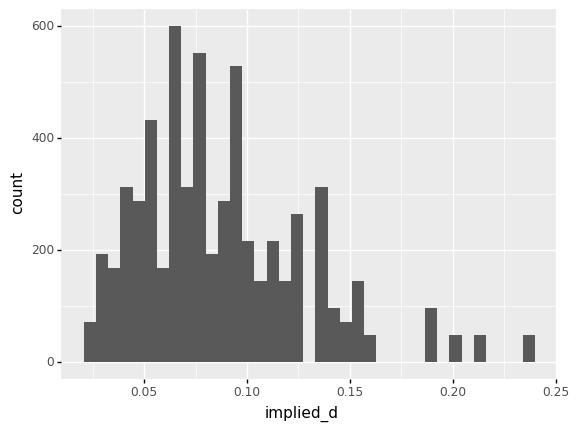

<ggplot: (-9223369079570985114)>

In [15]:
(
ggplot(sim_data, aes(x="implied_d")) + geom_histogram()
)

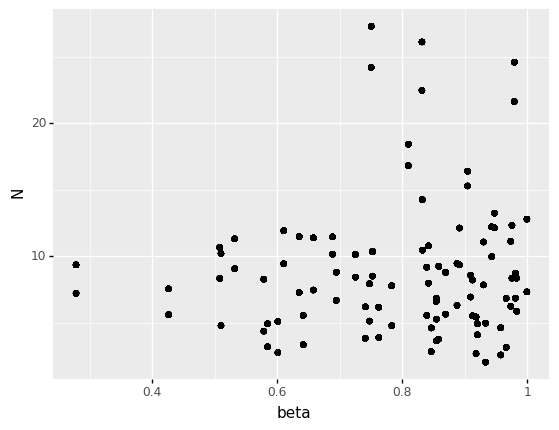

<ggplot: (2957286617846)>

In [16]:
(
ggplot(sim_data, aes(x="beta", y="N")) + geom_point()
)

In [20]:
df = (sim_data >>
      s.mutate(estimate =  np.round(_.estimate_ptn*20))
     )
df.estimate = df.estimate.astype("int64")

# sim_data["estimate"] = sim_data.estimate_bs
X_data, y_data = make_model_data(df) # see data_helpers.py
# X_data, y_data

In [19]:
y_data

DeviceArray([14,  2, 11, ...,  9,  3, 11], dtype=int64)

In [32]:
import tensorflow_probability as tfp
def prob_judge_BS(theta, X_num, X_denom, N, beta):

    pi = calc_prob(theta, X_num, X_denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)

    return p_bs

def prob_judge_BS_d(theta, X_num, X_denom, d):

    pi = calc_prob(theta, X_num, X_denom)
    return calc_ptn_prob(pi, d)


## rounding stuff
from jax import vmap

def spread_vec(x, step_size): # this works without static arguments
    base_steps = x.shape[0]
    x_split = jnp.split(x, base_steps)
    pad = jnp.zeros(step_size-1)
    probs = jnp.stack([jnp.concatenate((i,pad)) for i in x_split]).flatten()
    probs = probs[0:21]
    return probs/jnp.sum(probs)


def f(mu, k, responses):

    a = mu*k
    b = (1.-mu)*k

    n_resps = (responses.shape[0]-1)
    step = int(20/n_resps)
    rnd_unit_scaled = 1/n_resps

    lower = jnp.clip((responses/n_resps) - rnd_unit_scaled/2., 1e-8, 1-1e-8)
    upper = jnp.clip((responses/n_resps) + rnd_unit_scaled/2., 1e-8, 1-1e-8)

    prob_resps = tfp.math.betainc(a, b, upper) - tfp.math.betainc(a, b, lower)
    prob_resps = (spread_vec(prob_resps, step) + 1e-30)
    prob_resps = (prob_resps)/jnp.sum(prob_resps)
    # prob_resps = (prob_resps + 1e-30) / jnp.sum(prob_resps) # add err to prevent divergences

    return(prob_resps)


lbeta_cat_probs = vmap(f, (0, 0, None)) # change to map for k

responses_10 = jnp.linspace(0, 10, num=11)
responses_5 = jnp.linspace(0, 20, num=21)

def ptn_simplecond_mlm_trial_level_disc(data, y=None):

    # parameterized in terms of d and d' for comparison of model fit

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = jnp.unique(subj).shape[0], jnp.unique(cond).shape[0]

    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    # k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
    rnd_policy = numpyro.sample("rnd_policy", dist.Dirichlet(jnp.ones(3)))

    d_base_pop = numpyro.sample("d_base_pop", dist.Normal(-1.0, 1.0))
    d_delta_pop = numpyro.sample("d_delta_pop", dist.Normal(0, .5)) # bias toward lower values for non conj/disj trials
    d_base_sd = numpyro.sample("d_base_sd", dist.LogNormal(-1., 1.)) # was halfcauchy(1)
    d_delta_sd = numpyro.sample("d_delta_sd", dist.LogNormal(-1., 1.)) # approx uniform altogether we hope

    # subject-level parameters/priors
    with numpyro.plate("subj", n_Ps):
        d_bases = numpyro.sample("d_base_r", dist.Normal(0, 1))
        d_deltas = numpyro.sample("d_delta_r", dist.Normal(0, 1))
        ks = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter

    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    d_lin = (d_base_pop +
             d_bases[subj]*d_base_sd +
             jnp.exp(d_delta_pop + d_delta_sd*d_deltas[subj])*conjdisj
            )  # exp() constrains d_delta to be positive
    d = sigmoid(d_lin)/2.0 # require this be in [0, 1/3]

    numpyro.deterministic("d_subj", sigmoid(d_base_pop + d_bases*d_base_sd)/3.)
    numpyro.deterministic("d_prime_subj",
                          sigmoid(d_base_pop +
                                  d_bases*d_base_sd +
                                  jnp.exp(d_delta_pop + d_deltas*d_delta_sd)
                                 )/2.
                         )

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]

    p_bs = prob_judge_BS_d(theta, X_num, X_denom, d)
    k = ks[subj]

    resp_probs = (
        1./21.*rnd_policy[0] +
        lbeta_cat_probs(p_bs, k, responses_5)*rnd_policy[1] +
        lbeta_cat_probs(p_bs, k, responses_10)*rnd_policy[2]
    )

    # Likelihood
    with numpyro.plate("data", len(trial)):
        # yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
        yhat = numpyro.sample("yhat", dist.Categorical(probs=resp_probs), obs=y) # rounded
        return(yhat)



In [33]:
from numpyro.infer import init_to_median
kernel = NUTS(ptn_simplecond_mlm_trial_level_disc, target_accept_prob=.80, init_strategy=init_to_median(num_samples=30))
# kernel_bs = NUTS(mymodel, target_accept_prob=.80, init_strategy=init_to_sample())

mcmc = MCMC(kernel,
               num_warmup = 1_000,
               num_samples = 1_000,
               num_chains = 2,
               chain_method = "sequential"
              )

In [34]:
mcmc.run(random.PRNGKey(0), X_data, y_data)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)> with
  val = DeviceArray([ 9.62588341,  6.70369614,  7.90122928, ..., 12.89011451,
             13.24182361, 12.29259682], dtype=float64)
  batch_dim = 0
This Tracer was created on line <ipython-input-32-b7744c312a15>:29 (f)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [25]:
import pickle
import arviz as az
azdata = pickle.load(open("local/az-ptn_simplecond_mlm_trial_level_disc-exp2-2ksamples.p", "rb"))

In [26]:
azdata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

stray things below here 

---

In [59]:
import arviz as az

azdata = az.from_numpyro(mcmc_bs)
# mcmc_bs.get_samples()
# az.waic(numpyro_data)

In [62]:
import scipy
## pull out samples for each individual and match back up with data
## see if we're recovering the original parameters ...

def extract_samples(z, var_name):
    x1 = pd.DataFrame(np.array(z.posterior[var_name]))
    x1 = x1.reset_index() >> s.gather("draw", "value", -_.index) >> s.mutate(var = var_name)
    
    return(x1)

def posterior_to_df(az_data, var_list):
    # note variables must have same raw dimensions
    z = az_data.stack(sample=['chain','draw'])
    
    df_list = [extract_samples(z, v) for v in var_list]
    df = pd.concat(df_list)
    
    df = df >> s.spread("var", "value")
    
    return(df)


# azdata.posterior["N_prime"] = np.exp(azdata.posterior.N_prime_pop) + np.exp(azdata.posterior.N_prime_r)
# azdata.posterior["N_delta"] = np.exp(azdata.posterior.N_delta_pop) + np.exp(azdata.posterior.N_delta_r)
# azdata.posterior["beta"] = scipy.special.expit(azdata.posterior.beta_pop + azdata.posterior.beta_r)

# azdata.posterior.beta_pop

posterior_to_df(azdata, ["N_prime_pop", "N_delta_pop", "beta_pop"])


,index,draw,N_delta_pop,N_prime_pop,beta_pop
0,0,0,0.313077,3.156299,-1.550532
1,1,0,1.062099,3.382373,-2.370885
2,2,0,-1.191774,3.283893,-1.290284
3,3,0,-0.883830,3.176661,-0.320424
4,4,0,-0.609788,2.983621,-0.482756
...,...,...,...,...,...
1995,1995,0,1.140212,2.995460,-2.092002
1996,1996,0,0.741144,3.101146,-1.833318
1997,1997,0,-0.253611,3.065934,-1.528060
1998,1998,0,1.774047,3.129034,-2.950629


Posterior samples for $N$ and $\beta$ are highly correlated but they are still fairly well-identified, with the means getting the right answers.

Combining $N$ and $\beta$ to calculate $D$ shows that this is also correct.

true d =  0.029411764705882353


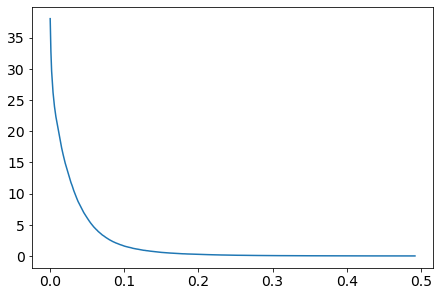

In [17]:
# can combine to form D
beta_post = numpyro_data.posterior.beta
N_post = numpyro_data.posterior.N_delta + numpyro_data.posterior.N_prime

d_post = beta_post/(N_post+2*beta_post)

az.plot_dist(d_post)
print("true d = ", .5/(16+1))

# PT+N simulations

This isn't quite working, I can't seem to get the parameters back out.

In [284]:

params_ptn = {
    "d_base": {k: .03 for k in range(0,n_participants)},
    "d_delta": {k: .2 for k in range(0,n_participants)},
    "k":40
}

def calc_ptnprob(trial, theta, d):
    
    if is_cond(trial):
        X_num = num_vecs[trial]
        X_denom = denom_vecs[trial]
        X_A = pA_vecs[trial]
        
        p_numerator = np.sum(theta*X_num, axis=-1) #  = P(A & B)
        pA = np.sum(theta*X_A, axis=-1)
        num_or_denom = np.logical_or(X_A, X_denom).astype("float32")
        p_num_or_denom = np.sum(theta * num_or_denom , axis=-1) # = P(A or B)


        p_denom = np.sum(theta*X_denom, axis=-1)
        numerator = (p_numerator)*(1-2*d)**2 + d*(1-2*d)*(pA + p_denom) + d**2
        denom = ((1 - 2*d)*p_denom  + d)
        p_ptn = numerator/denom

        return p_ptn

    else:
        X_num = num_vecs[trial]
        X_denom = denom_vecs[trial]

        numerator = np.sum(theta*X_num, axis=-1)
        denom = np.sum(theta*X_denom, axis=-1)
        pi = np.divide(numerator, denom)
        p_ptn = (1 - 2*d)*pi  + d

        return p_ptn

def sim_PTN(trial_types, n_participants, n_blocks, params):

    n_trial_types = len(trial_types)
    trials = trial_types*n_blocks
    conds = np.tile(np.arange(0,n_blocks).repeat(len(trial_types)), n_participants)
    blocks = list(np.repeat(np.array(list(range(0, n_blocks))), n_trial_types))

    all_participants = list(np.repeat(np.array(list(range(0, n_participants))), n_trial_types*n_blocks))
    all_thetas = make_thetas(n_participants)
    all_trials = trials*n_participants
    all_blocks = blocks*n_participants

    sim_data = pd.DataFrame(
        data = {
            "ID": all_participants,
            "querytype": all_trials, 
            "block": all_blocks,
            "coldrainy": conds
        }) >> mutate(
            conjdisj_trial = X.querytype.apply(is_conjdisj),
            cond_trial = X.querytype.apply(is_cond),
            d_base = X.ID.apply(lambda x: params["d_base"][x]),
            d_delta = X.ID.apply(lambda x: params["d_delta"][x]),
        theta = X.ID.apply(lambda x: all_thetas[x])
        ) >> mutate(d = X.d_base + X.d_delta * X.conjdisj_trial)

    sim_data["prob"] = sim_data.apply(lambda x: calc_ptnprob(x.querytype, x.theta, x.d), axis=1)
    sim_data["estimate"] = sim_data.prob.apply(lambda x: np.random.beta(x*params["k"], (1-x)*params["k"]))
#     sim_data["estimate"] = sim_data.apply(lambda x: sim_sampling(x.prob, x.beta, x.N, params["k"]), axis=1)
    
    return sim_data

sim_data2 = sim_PTN(trial_types, 1, 10, params_ptn)
X_data, y_data = make_model_data(sim_data2) # see data_helpers.py

In [285]:
# sim_data2
calc_ptnprob("AandB",np.array([.3,.2,.1,.4]), .1)


0.34000000953674314

In [292]:
def prob_judge_PTN(trial, theta, X_num, X_denom, X_A, d):
    conditional = jnp.array([is_cond(i) for i in trial])
    not_conditional = abs(1-conditional)
    p_numerator = jnp.sum(theta*X_num, axis=-1) #  = P(A & B)
    pA = jnp.sum(theta*X_A, axis=-1)
    num_or_denom = jnp.logical_or(X_A, X_denom).astype("float32")
    p_num_or_denom = jnp.sum(theta * num_or_denom , axis=-1) # = P(A or B)


    p_denom = jnp.sum(theta*X_denom, axis=-1)
    numerator = ((p_numerator)*(1-2*d)**2 + d*(1-2*d)*(pA + p_denom) + d**2)*conditional + ((1 - 2*d)*p_numerator + d)*not_conditional
    denom = ((1 - 2*d)*p_denom  + d)*conditional + p_denom*not_conditional
    
    return jnp.divide(numerator, denom) # move division to after noise is added

def PTN_complex(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    X_A = jnp.stack([pA_vecs[i] for i in trial])
    
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter

    # Subject-level parameters/priors
    with numpyro.plate("subj", n_Ps):
        d_bases = numpyro.sample("d_base", dist.Normal(0, 2))
        d_deltas = numpyro.sample("d_delta", dist.Normal(0, .2))
        
    # Subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    d_lin = d_bases[subj] + jnp.exp(d_deltas[subj]) * conjdisj # constrain d' > d
#     d_lin = d_bases[subj]*not_conjdisj + d_deltas[subj]*conjdisj
    d = sigmoid(d_lin)/2. # require this be below .50
    
    theta_ind = (subj*2) + cond
    theta = thetas[theta_ind,:]
    
    p_ptn = prob_judge_PTN(trial, theta, X_num, X_denom, X_A, d)

    # Likelihood
    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(p_ptn, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(p_ptn*k, (1-p_ptn)*k), obs=y)
    
    return yhat

In [293]:
mcmc_ptn = MCMC(NUTS(PTN_complex, target_accept_prob=.80), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=1)

mcmc_ptn.run(random.PRNGKey(0), X_data, y_data)

sample: 100%|██████████| 4000/4000 [00:09<00:00, 417.88it/s, 15 steps of size 2.99e-01. acc. prob=0.90]


In [60]:
mcmc_ptn.print_summary()

NameError: name 'mcmc_ptn' is not defined

3/24/21, 4:58 PM: Working! (earlier problem was simulation bug)